In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, plot_det_curve

plt.style.use('bmh')

In [2]:
def classifier_evaluation(estimator, X, y):
    y_pred = estimator.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"Accuracy: {acc*100:.2f}%")
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    plot_confusion_matrix(estimator, X, y, ax=ax[0,0], cmap='Blues')
    plot_roc_curve(estimator, X, y, ax=ax[0,1])
    plot_precision_recall_curve(estimator, X, y, ax=ax[1,0])
    plot_det_curve(estimator, X, y, ax=ax[1,1])
    plt.tight_layout()
    plt.show()

In [3]:
data = pd.read_excel('default of credit card clients.xls', index_col=0, header=1)
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
X = data.copy(deep=True)
y = X.pop('default payment next month')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

In [5]:
print('Train labels')
print(y_train.value_counts(normalize=True))
print('-'*50)
print('Test labels')
print(y_test.value_counts(normalize=True))

Train labels
0    0.77881
1    0.22119
Name: default payment next month, dtype: float64
--------------------------------------------------
Test labels
0    0.778778
1    0.221222
Name: default payment next month, dtype: float64


In [6]:
estimators = [('LogisticReg', make_pipeline(StandardScaler(), LogisticRegression())),
              ('KNN', make_pipeline(StandardScaler(), KNeighborsClassifier())),
              ('DecisionTree', DecisionTreeClassifier()),
              ('GaussianNB', make_pipeline(StandardScaler(), GaussianNB())),
              ('SVC', make_pipeline(StandardScaler(), SVC()))]

In [7]:
print('*** Accuracy Train/Test ***')
for models in estimators:
    name = models[0]
    estimator = models[1]
    estimator.fit(X_train, y_train)
    train_acc = estimator.score(X_train, y_train)
    test_acc = estimator.score(X_test, y_test)
    
    print(f"{name:12s} ----> {train_acc*100:.2f}%/{test_acc*100:.2f}%")

*** Accuracy Train/Test ***
LogisticReg  ----> 80.97%/81.12%
KNN          ----> 84.16%/79.06%
DecisionTree ----> 99.94%/72.28%
GaussianNB   ----> 57.17%/57.23%
SVC          ----> 82.40%/82.27%


In [8]:
kfold = StratifiedKFold(5, shuffle=True)
stack_clf = StackingClassifier(estimators=estimators, 
                               final_estimator=LogisticRegression(),
                               cv=kfold, n_jobs=4)

In [9]:
stack_clf.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x7F3A7708F840, shuffle=True),
                   estimators=[('LogisticReg',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression())])),
                               ('KNN',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())])),
                               ('DecisionTree', DecisionTreeClassifier()),
                               ('GaussianNB',
                                Pipeline(steps=[('standardscaler',
                                  

In [10]:
print(f"Train score: {stack_clf.score(X_train, y_train)*100:.2f}%")
print(f"Test score: {stack_clf.score(X_test, y_test)*100:.2f}%")

Train score: 83.43%
Test score: 82.14%


Accuracy: 82.14%


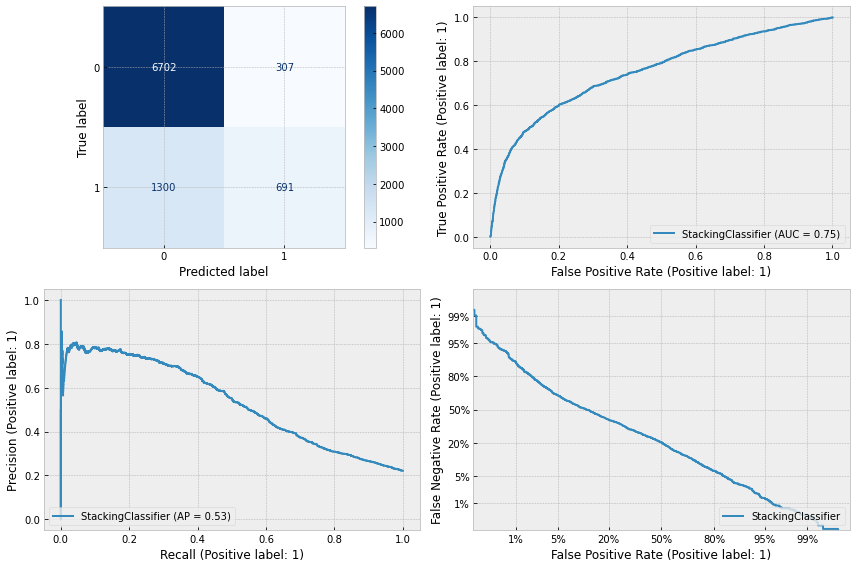

In [11]:
classifier_evaluation(stack_clf, X_test, y_test)